# Visión por Computadora II - TP Integrador

**Dataset**: [fruits-360](https://www.kaggle.com/datasets/moltean/fruits)

In [2]:
# importamos librerias
import os
import gdown
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

---
## 1) Dataset

In [3]:
dataset_zip = 'fruits-360_100x100.zip'
%store dataset_zip

# Descargar el dataset
if os.access(dataset_zip, os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL'
    gdown.download(url, dataset_zip)
else:
    print("El dataset ya se encuentra descargado")

Stored 'dataset_zip' (str)


Downloading...
From (original): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL
From (redirected): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL&confirm=t&uuid=a1657ea1-dff2-4aa0-ae4c-6f125dd1cbdb
To: /content/fruits-360_100x100.zip
100%|██████████| 423M/423M [00:14<00:00, 29.3MB/s]


In [4]:
!unzip -q "$dataset_zip"

### 1.1) Visualización de los datos

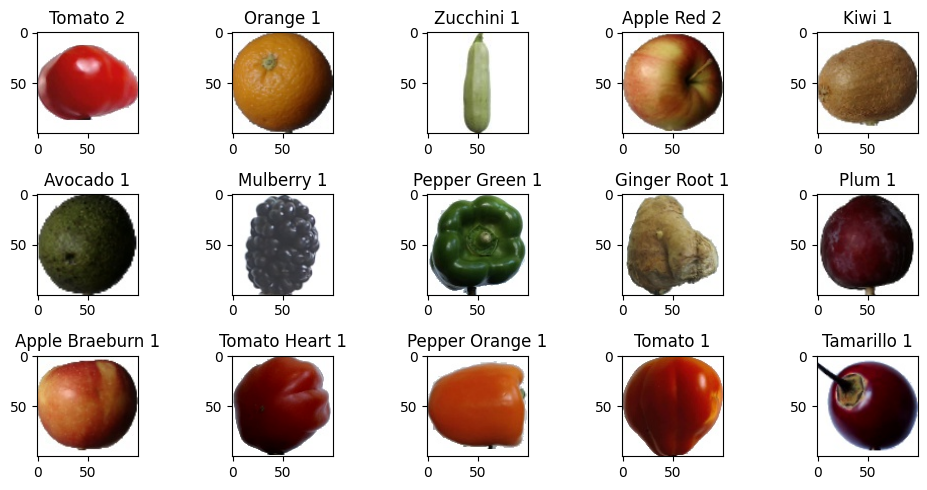

In [12]:
train_folder = 'Training/'

fig, axs = plt.subplots(3, 5, figsize=(10, 5))
axs = axs.ravel()

random.seed(42)
class_folders = sorted(os.listdir(train_folder))
random_class_folders = class_folders[:]
random.shuffle(random_class_folders)
num_images_to_display = min(len(class_folders), len(axs))

for i in range(num_images_to_display):
    class_folder_path = os.path.join(train_folder, random_class_folders[i])
    image_files = os.listdir(class_folder_path)
    image_name = random.choice(image_files)
    image_path = os.path.join(class_folder_path, image_name)
    image = mpimg.imread(image_path)
    axs[i].imshow(image)
    axs[i].set_title(random_class_folders[i])

plt.tight_layout()
plt.show()

---
### 1.2) Data Augmentation



In [13]:
# wip

---
## 2) Modelos

### 2.1) Modelo 1: ?

In [ ]:
# wip

---
### 2.1) Modelo 2: ?

In [14]:
# wip